# Test Python Package Build

In [ ]:
from dsa_helpers.girder_utils import login
from os import getenv

# Load environmental variables from .env file.
from dotenv import load_dotenv
load_dotenv(".env")

gc = login(getenv("DSA_API_URL"), api_key=getenv("DSA_API_KEY"))

# Test out a the get ROIs in Pearce format.
from dsa_helpers.ml.object_detection import get_pearce_roi_images

class_map = {
    "Diffuse": 0,
    "Cored": 1,
    "Dyshoric": 2,
    "CAA": 3
}

get_pearce_roi_images(gc, "6667621c772321aebc120809", class_map=class_map)
from dsa_helpers.ml.object_detection import tile_image

tile_image(
    "images/itemId-6667621c772321aebc120809-x26937y594x32666y3791.png",
    "labels/itemId-6667621c772321aebc120809-x26937y594x32666y3791.txt",
    "tiles",
)

In [1]:
from dsa_helpers import imread

img = imread("images/itemId-6667621c772321aebc120809-x26937y594x32666y3791.png")[:, :, :3]

In [2]:
h, w = img.shape[:2]

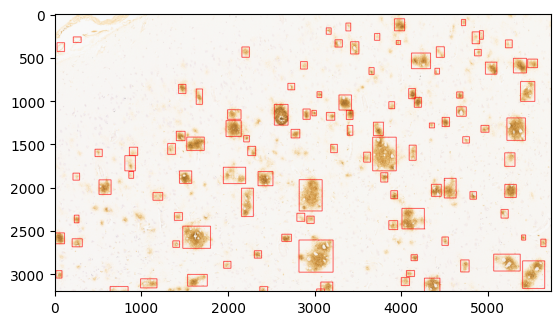

In [8]:
from dsa_helpers.ml.object_detection.utils import read_yolo_label
import numpy as np
np.set_printoptions(suppress=True)

labels = read_yolo_label(
    "labels/itemId-6667621c772321aebc120809-x26937y594x32666y3791.txt",
    (w, h),
    convert=True
)

import cv2 as cv

# Draw the bounding boxes on the image.
contours = []

for label in labels:
    x1, y1, x2, y2 = label[1:].astype(int)
    x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
    
    contours.append(np.array([
        (x1, y1),
        (x2, y1),
        (x2, y2),
        (x1, y2)
    ]))
    
img_w_boxes = cv.drawContours(img.copy(), contours, -1, (255, 0, 0), 5)

import matplotlib.pyplot as plt
plt.imshow(img_w_boxes)
plt.show()

In [6]:
contours

[[(2528, 1043), (2686, 1043), (2686, 1282), (2528, 1282)],
 [(1971, 1231), (2146, 1231), (2146, 1414), (1971, 1414)],
 [(1519, 1420), (1720, 1420), (1720, 1574), (1519, 1574)],
 [(2340, 1818), (2512, 1818), (2512, 1982), (2340, 1982)],
 [(2858, 1096), (2941, 1096), (2941, 1215), (2858, 1215)],
 [(2961, 1112), (3012, 1112), (3012, 1175), (2961, 1175)],
 [(3020, 897), (3075, 897), (3075, 964), (3020, 964)],
 [(2684, 800), (2763, 800), (2763, 875), (2684, 875)],
 [(3273, 934), (3417, 934), (3417, 1108), (3273, 1108)],
 [(3358, 1112), (3435, 1112), (3435, 1217), (3358, 1217)],
 [(3368, 1286), (3433, 1286), (3433, 1399), (3368, 1399)],
 [(3128, 1136), (3225, 1136), (3225, 1225), (3128, 1225)],
 [(2721, 1331), (2822, 1331), (2822, 1430), (2721, 1430)],
 [(1424, 812), (1509, 812), (1509, 917), (1424, 917)],
 [(1627, 865), (1700, 865), (1700, 1042), (1627, 1042)],
 [(1398, 1353), (1499, 1353), (1499, 1462), (1398, 1462)],
 [(1435, 1811), (1576, 1811), (1576, 1954), (1435, 1954)],
 [(23, 331), 